# Lesson 6.动态计算图与梯度下降入门

我们将继续讲解AutoGrad模块中的其他常用功能，并在此基础上介绍另一个常用优化算法：梯度下降算法

In [19]:
import numpy as np
import torch

## 一、AutoGrad的回溯机制与动态计算图

### 1.可微分性相关属性

张量可以支持微分运算

- `requires_grad`属性：可微分性
- `grad_fn`属性：存储Tensor微分函数

In [20]:
# 构建可微分张量
x = torch.tensor(1.,requires_grad = True)
x

tensor(1., requires_grad=True)

In [21]:
# 构建函数关系
y =  x ** 2
y

tensor(1., grad_fn=<PowBackward0>)

我们发现，此时张量y具有了一个`grad_fn`属性，并且取值为`<PowBackward0>`，我们可以查看该属性

In [22]:
y.grad_fn

`grad_fn`其实是存储了Tensor的微分函数，或者说`grad_fn`存储了可微分张量在进行计算的过程中函数关系，此处x到y其实就是进行了幂运算。

In [23]:
# 但x作为初始张量，并没有grad_fn属性
x.grad_fn

In [24]:
# y 是由可微分的张量生成的也可微分
y.requires_grad

True

In [25]:
# 尝试建立新的函数关系

z = y + 1
z

tensor(2., grad_fn=<AddBackward0>)

In [26]:
z.requires_grad

True

In [27]:
z.grad_fn

# z也同时存储了张量计算数值、z是可微的，并且z还存储了和y的计算关系（add）。

如果我们设置初始张量是可微的，则在计算过程中，每一个由原张量计算得出的新张量都是可微的，并且还会保存此前一步的函数关系，这也就是所谓的回溯机制。

### 2.张量计算图

&emsp;&emsp;借助回溯机制，我们就能将张量的复杂计算过程抽象为一张图（Graph）

- 计算图的定义
记录可微分张量计算关系的张量计算图，图由节点和有向边构成，其中节点表示张量，边表示函数计算关系，方向则表示实际运算方向，张量计算图本质是有向无环图。

- 节点类型
  - 叶节点，也就是初始输入的可微分张量，前例中x就是叶节点；      
  - 输出节点，也就是最后计算得出的张量，前例中z就是输出节点；      
  - 中间节点，在一张计算图中，除了叶节点和输出节点，其他都是中间节点，前例中y就是中间节点。 


### 3.计算图的动态性

- 张量计算图会随着张量变换

PyTorch的计算图是动态计算图，会根据可微分张量的计算过程自动生成，并且伴随着新张量或运算的加入不断更新，这使得PyTorch的计算图更加灵活高效，并且更加易于构建，

## 二、反向传播与梯度计算

### 1.反向传播的基本过程

&emsp;&emsp;在《Lesson 5.》中，我们曾使用autograd.grad进行函数某一点的导数值得计算，其实，除了使用函数以外，我们还有另一种方法，也能进行导数运算：反向传播。当然，此时导数运算结果我们也可以有另一种解读：计算梯度结果。

首先，对于某一个可微分张量的导数值（梯度值），存储在grad属性中。

- .backward() 反向传播后，即可查看叶节点中的到数值
- 两次反向传播就会报错

In [28]:
x

tensor(1., requires_grad=True)

In [29]:
x.grad

In [30]:
z

tensor(2., grad_fn=<AddBackward0>)

In [31]:
z.grad_fn

In [32]:
# 执行反向传播
z.backward()

In [33]:
# 反向传播结束后，即可查看叶节点的导数值
x

tensor(1., requires_grad=True)

In [34]:
# 在z=y+1=x**2+1函数关系基础上，x取值为1时的导数值
x.grad

tensor(2.)

注意，在默认情况下，在一张计算图上执行反向传播，只能计算一次，再次调用backward方法将报错

In [35]:
z.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [36]:
# 在y上也能反向传播
x = torch.tensor(1.,requires_grad = True)
y = x ** 2
z = y + 1

y.backward()
x.grad

# y.backward()  第二次执行也会报错

tensor(2.)

**反向传播的基本概念和使用方法：**     
- 本质：函数关系的反向传播（不是反函数）； 
- 执行条件：拥有函数关系的可微分张量（计算图中除了叶节点的其他节点）；
- 函数作用：计算叶节点的导数/微分/梯度运算结果；

### 2.反向传播运算注意事项

- 中间节点反向传播和输出节点反向传播区别

&emsp;&emsp;尽管中间节点也可进行反向传播，但很多时候由于存在复合函数关系，中间节点反向传播的计算结果和输出节点反向传播输出结果并不相同。

In [38]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 2
z = y ** 2

# x -> y -> z
z.backward()
x.grad

tensor(4.)

In [39]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 2
z = y ** 2

# x -> y -> z

y.backward()
x.grad

tensor(2.)

- 中间节点的梯度保存
  - 默认情况下，在反向传播过程中，中间节点并不会保存梯度
  - 保存中间节点的梯度，`retain_grad()`方法

In [40]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 2
z = y ** 2


In [41]:
z.backward()
y.grad


g:\py\lib\site-packages\torch\_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:482.)
  return self._grad


In [42]:
x.grad

tensor(4.)

若想保存中间节点的梯度，我们可以使用retain_grad()方法

In [43]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 2
y.retain_grad()
z = y ** 2

z.backward()
y

tensor(1., grad_fn=<PowBackward0>)

In [44]:
y.grad

# z对y求导为2y，又y=1 返回2

tensor(2.)

In [45]:
x.grad

tensor(4.)

### 3.组织计算图的追踪

&emsp;&emsp;在默认情况下，只要初始张量是可微分张量，系统就会自动追踪其相关运算，并保存在计算图关系中，我们也可通过grad_fn来查看记录的函数关系

但在特殊的情况下，我们并不希望可微张量从创建到运算结果输出都被记录，此时就可以使用一些方法来阻止部分运算被记录。

- `with torch.no_grad()`：阻止计算图记录
  - with 上下文管理器
- `.detach()`方法: 创建一个不可导的相同张量

In [46]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 2


In [47]:
with torch.no_grad():
    z = y ** 2   
    # z的grad属性被屏蔽了 不纳入计算图

with相当于是一个上下文管理器，with torch.no_grad()内部代码都“屏蔽”了计算图的追踪记录

In [48]:
z

tensor(1.)

In [49]:
z.requires_grad

False

In [50]:
y

tensor(1., grad_fn=<PowBackward0>)

In [51]:
# 在某些情况下，我们也可以创建一个不可导的相同张量参与后续运算，从而阻断计算图的追踪

x = torch.tensor(1.,requires_grad = True)
y = x ** 2
y1 = y.detach()  # 创建不可导的张量
z = y1 ** 2  
# 在不可导的张量上建立新的张量也是不可微的

In [52]:
y

tensor(1., grad_fn=<PowBackward0>)

In [53]:
y1

tensor(1.)

In [54]:
z

tensor(1.)

### 4.识别叶节点

- 此处的叶节点为 只有出边没有入边（类似根节点）

&emsp;&emsp;由于叶节点较为特殊，如果需要识别在一个计算图中某张量是否是叶节点，可以使用`is_leaf`属性查看对应张量是否是叶节点。

In [55]:
x.is_leaf

True

In [56]:
y.is_leaf

False

- 新创建的张量都可以是叶节点

但is_leaf方法也有容易混淆的地方，对于任何一个新创建的张量，无论是否可导、是否加入计算图，都是可以是叶节点，这些节点距离真正的叶节点，只差一个requires_grad属性调整。

In [57]:
torch.tensor([1]).is_leaf

True

In [58]:
# 经过detach的张量，也可以是叶节点
y1

tensor(1.)

In [59]:
y1.is_leaf

True

## 三、梯度下降基本思想

### 1.最小二乘法的局限和优化

在所有的优化算法中最小二乘法虽然高效并且结果精确，但最小二乘法的使用条件较为苛刻，要求特征张量的交叉乘积结果$X^TX$必须是满秩矩阵，才能进行求解。

而在实际情况中，很多数据的特征张量并不能满足条件，此时就无法使用最小二乘法进行求解。

- 在Lasso中加入L2正则项，可以避险多重共线性的存在
- 在岭回归中加入L1正则项，可以避免逆矩阵不存在的问题
  
最小二乘法结果：
$$\hat w ^T = (X^TX)^{-1}X^Ty$$
我们可以在原矩阵方程中加入一个扰动项$\lambda I$，修改后表达式如下：
$$\hat w ^{T*} = (X^TX + \lambda I)^{-1}X^Ty$$
其中，$\lambda$是扰动项系数，$I$是单元矩阵。由矩阵性质可知，加入单位矩阵后，$(X^TX + \lambda I)$部分一定可逆，而后即可直接求解$\hat w^{T*}$，这也就是岭回归的一般做法。

### 2.梯度下降核心思想

核心就是希望能够通过数学意义上的迭代运算，从一个随机点出发，一步步逼近最优解。

In [60]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

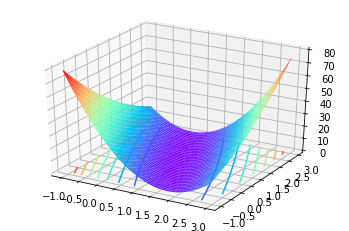

In [63]:
x = np.arange(-1,3,0.05)
y = np.arange(-1,3,0.05)
a, b = np.meshgrid(x, y)
SSE = (2 - a - b) ** 2 + (4 - 3 * a - b) ** 2

fig = plt.figure()  
ax = plt.axes(projection='3d')

ax.plot_surface(a, b, SSE, cmap='rainbow')
ax.contour(a, b, SSE, zdir='z', offset=0, cmap="rainbow")  #生成z方向投影，投到x-y平面
plt.show()

而梯度下降，作为最优化算法，核心目标也是找到或者逼近最小值点，而其基本过程则：
- 在目标函数上随机找到一个初始点；
- 通过迭代运算，一步步逼近最小值点；

<img src="https://i.loli.net/2021/01/23/caNAtMFI5dqhfH6.jpg" alt="11" style="zoom:50%;" />

> 数学意义上的迭代运算，指的是上一次计算的结果作为下一次运算的初始条件带入运算

### 3.梯度下降的方向与步长

我们核心需要解决两个问题，其一是往哪个方向走，其二是每一步走多远，而这些就是梯度下降算法核心需要解决的问题，也就是所谓的**方向和步长**。

- **方向**  
梯度下降是采用了一种局部最优推导全域最优的思路，我们首先是希望能够找到让目标函数变化最快的方向作为移动的方向，而这个方向，就是梯度。

#### 3.1 导数与梯度

梯度本身是一个代表方向的矢量，代表某一函数在该点处沿着梯度方向变化时，变化率最大。当然，梯度的正方向代表函数值增长最快的方向，梯度的负方向表示函数减少最快的方向

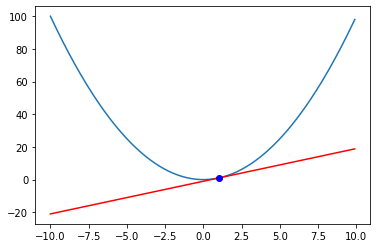

In [64]:
x = np.arange(-10,10,0.1)
y = x ** 2                          # y = 2x
z = 2 * x - 1                       # 在（1，1）点的切线方程
plt.plot(x, y, '-')
plt.plot(x, z, 'r-')
plt.plot(1, 1, 'bo')
plt.show()

#### 3.2 梯度与方向


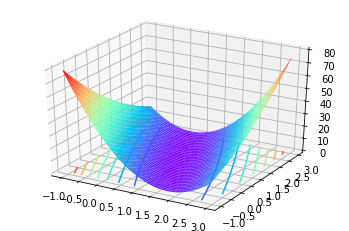

In [65]:
# 回顾图形
fig = plt.figure()  
ax = plt.axes(projection='3d')

ax.plot_surface(a, b, SSE, cmap='rainbow')
ax.contour(a, b, SSE, zdir='z', offset=0, cmap="rainbow")  #生成z方向投影，投到x-y平面
plt.show()

此时a、b是在实数域上取值。假设二者初始值为0，也就是初始随机点为原点。对于（0，0）点，有梯度计算如下

In [66]:
a = torch.tensor(0., requires_grad = True)
a

tensor(0., requires_grad=True)

In [67]:
b = torch.tensor(0., requires_grad = True)
b

tensor(0., requires_grad=True)

In [68]:
# 设定0,0点的SSE
s0 = torch.pow((2 - a - b), 2) + torch.pow((4 - 3 * a - b), 2)

In [69]:
s0

tensor(20., grad_fn=<AddBackward0>)

In [70]:
s0.backward()

In [71]:
a.grad,b.grad   

(tensor(-28.), tensor(-12.))

也就是原点和（-28，-12）这个点之间连成直线的方向，就是能够使得sse变化最快的方向，并且朝向（-28，-12）方向就是使得sse增加最快的方向，反方向则是令sse减少最快的方向。

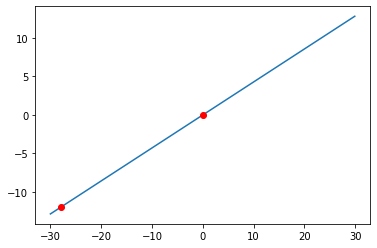

In [72]:
# 通过绘制直线，确定原点的移动方向
x = np.arange(-30,30,0.1)
y = (12/28) * x                     
plt.plot(x, y, '-')
plt.plot(0, 0, 'ro')
plt.plot(-28, -12, 'ro')

**Point**: 这里有关于方向的两点讨论      
- 方向没有大小，虽然这是个显而易见的观点，但我们当我们说朝着（-28，-12）方向移动，只是说沿着直线移动，并非一步移动到（-28，-12）上；      
- 方向跟随梯度，随时在发生变化。值得注意的是，一旦点发生移动，梯度就会随之发生变化，也就是说，哪怕是沿着让sse变化最快的方向移动，一旦“沿着方向”移动了一小步，这个方向就不再是最优方向了。

In [73]:
s0

tensor(20., grad_fn=<AddBackward0>)

当然，逆梯度值的方向变化是使得SSE变小的最快方向，我们尝试移动“一小步”。

一步移动到(28,12)是没有意义的，梯度各分量数值的绝对值本身也没有距离这个层面的数学含义。由于a和b的取值要按照（28，12）等比例变化，因此我们不妨采用如下方法进行移动：

$$ \left [\begin{array}{cccc}
0 \\
0 \\
\end{array}\right] + 0.01 * 
\left [\begin{array}{cccc}
28 \\
12 \\
\end{array}\right] =
\left [\begin{array}{cccc}
0.28 \\
0.12 \\
\end{array}\right]$$


- 0.01就是步长，又称作学习率

In [74]:
# 移动 a b
a = torch.tensor(0.28, requires_grad = True)
a

tensor(0.2800, requires_grad=True)

In [75]:
b = torch.tensor(0.12, requires_grad = True)
b

tensor(0.1200, requires_grad=True)

In [76]:
s1 = (2 - a - b) ** 2 + (4 - 3 * a - b) ** 2
s1

# SSE下降，求解新的梯度

tensor(11.8016, grad_fn=<AddBackward0>)

In [77]:
s1.backward()
a.grad,b.grad

# 其实无论移动“多小”一步，只要移动，方向就需要重新计算。

(tensor(-21.4400), tensor(-9.2800))

- 将上述0.01称作学习率，而学习率乘以梯度，则是原点移动的“长度”。

当然，在移动到(0.28,0.12)之后，还没有取到全域最优解，因此还需要继续移动，当然我们还可以继续按照0.01这个学习率继续移动，此时，新的梯度为（-21.44,-9.28)，则有

$$ \left [\begin{array}{cccc}
0.28 \\
0.12 \\
\end{array}\right] + 0.01 * 
\left [\begin{array}{cccc}
21.44 \\
9.28 \\
\end{array}\right] =
\left [\begin{array}{cccc}
0.4944 \\
0.2128 \\
\end{array}\right]$$


接下来，我们可以继续计算新的(0.94,0.148)这个点的梯度，然后继续按照学习率0.01继续移动，在移动若干次之后，就将得到非常接近于（1，1）的结果。


## 四、梯度下降的数学表示

### 1.梯度下降的代数表示

令多元线性回归方程为
$$ f(x) = w_1x_1+w_2x_2+...+w_dx_d+b $$
令
$$\hat w = (w_1,w_2,...,w_d,b)$$
$$\hat x = (x_1,x_2,...,x_d,1)$$
出于加快迭代收敛速度的目标，我们在定义梯度下降的损失函数L时，在原SSE基础上进行比例修正，新的损失函数$L(w_1,w_2,...,w_d,b) = \frac{1}{2m}SSE$，其中，m为样本个数。

**损失函数有**：
 $$
   L(w_1,w_2,...,w_d,b) = \frac{1}{2m}\sum_{j=0}^{m}(f(x_1^{(j)}, x_2^{(j)}, ...1) - y_j)^2
$$



在开始梯度下降求解参数之前，我们首先需要设置一组参数的初始取值$(w_1, w_2..., w_d, b)$，以及学习率$\alpha$，然后即可执行迭代运算，其中每一轮迭代过程需要执行以下三步

- **迭代过程**

**Step 1.计算梯度表达式** 

对于任意一个参数$w_i$，其梯度计算表达式如下：
$$\frac{\partial}{\partial w_i}L(w_1, w_2..., w_d, b)$$

**Step 2.用学习率乘以损失函数梯度，得到迭代移动距离**
$$\alpha \frac{\partial}{\partial w_i}L(w_1, w_2..., w_d, b)$$

**Step 3.用原参数减Step 2中计算得到的距离，更新所有的参数w**
$$w_i = w_i - \alpha \frac{\partial}{\partial w_i}L(w_1, w_2..., w_d, b)$$


更新完所有参数，即完成了一轮的迭代，接下来就能以新的一组$w_i$参与下一轮迭代。

- 停止迭代，
  1. 设置迭代次数，到达迭代次数即停止迭代；
  2. 二是设置收敛区间，即当某两次迭代过程中，每个$w_i$更新的数值都小于某个预设的值，则停止迭代。

### 2.再次理解步长

有数据集表示如下：
|x|y|
| :------: | :------: |
| 1 | 2 |
| 2 | 4 |
| 3 | 6 |

假设，我们使用$y = wx$进行拟合，则SSE为：
$$ \begin{align} SSE
& = (2-1*w)^2 + (4-2*w)^2 + (6-3*w)^2 \\
& = 14(w^2-4w+4)  \end{align} $$
SE对于w求导为0的点就是最小值点，因此有：
$ \begin{align} \frac{\partial{SSE_{(a)}}}{\partial{(a)}}  
& = 14(2w-4)\\
& = 0  \end{align} $
$$w=2$$


**使用梯度下降**
$ \begin{align} 
grad^*
& = \frac{\partial{SSE_{(a)}}}{\partial{(a)}} \\
& = 28(w-2) \\
\end{align} $

由于梯度表示方向，在某些情况下我们可以对其绝对数值进行一定程度上的“缩放”，此时我们规定有效梯度是原梯度的1/28，则有
$$grad = w-2 $$
设步长$\alpha=0.5$，初始值点取为$w_0=0$，则迭代过程如下：
- 第一轮迭代：  
$$grad(w_0)=grad(0)=-2,w_0=0,$$
$$w_1=w_0-\alpha*grad(w_0)=0-\frac{1}{2}(-2)=1$$

- 第二轮迭代：
$$grad(w_1)=grad(1)=-1,w_1=1,$$
$$w_2=w_1-\alpha*grad(w_1)=1-\frac{1}{2}(-1)=\frac{3}{2}$$

- 第三轮迭代：
$$grad(w_2)=grad(\frac{3}{2})=-\frac{1}{2},w_2=\frac{3}{2},$$
$$w_3=w_2-\alpha*grad(w_2)=\frac{3}{2}-\frac{1}{2}(-\frac{1}{2})=\frac{7}{4}$$

- 无限次迭代后：
$$\lim_{n→\infty} (w_n) = \lim_{n→\infty} (2-\frac{1}{2^{n-1}}) = 2$$

如果损失函数是凸函数，并且全域最小值存在，则步长可以表示当前点和最小值点之间距离的比例关系。
- 步长太短：会极大的影响迭代收敛的时间，整体计算效率会非常低；
- 步长太长：容易跳过最优解，导致结果震荡。

### 3.梯度下降的矩阵表示

方程为:
$$f(x) = \hat w * \hat x^T$$

我们将所有自变量的值放在一个矩阵中，并且和此前A矩阵类似，为了捕捉截距，添加一列全为1的列在矩阵的末尾，设总共有m组取值，则
$$ X = 
\left [\begin{array}{cccc}
x_{11} &x_{12} &... &x_{1d} &1 \\
x_{21} &x_{22} &... &x_{2d} &1 \\
... &... &... &... &1 \\
x_{m1} &x_{12} &... &x_{md} &1 \\
\end{array}\right]
$$
对应到前例中的A矩阵，A矩阵就是拥有一个自变量、两个取值的X矩阵。令y为自变量的取值，则有
$$ y =  \left [\begin{array}{cccc}
y_1 \\
y_2 \\
. \\
. \\
. \\
y_m \\
\end{array}\right] $$



SSE可以表示为：
$$SSE = ||y - X\hat w^T||_2^2 = (y - X\hat w^T)^T(y - X\hat w^T) = E(\hat w)$$

梯度下降损失函数为：
$$L(\hat w) = \frac{1}{2m} SSE =\frac{1}{2m} (y - X\hat w^T)^T(y - X\hat w^T) $$



**梯度下降的过程**

1. 计算梯度表达式
$$\frac{\partial}{\partial \hat w}L(\hat w) = \frac{1}{m}X^T(X\hat w ^T - Y)$$
2. 用学习率乘以损失函数梯度，得到迭代移动距离
$$\alpha \frac{\partial}{\partial \hat w}L(\hat w)$$
3. 用原参数减Step 2中计算得到的距离，更新所有的参数w
$$\hat w = \hat w - \alpha \frac{\partial}{\partial \hat w}L(\hat w) = \hat w - \frac{\alpha}{m}X^T(X\hat w ^T - Y)$$

## 五、手动实现梯度下降

利用autograd中梯度计算的功能

- 例子
$ 1*a + b = 2 $ 
$ 3*a + b = 4 $
令
$$ X = 
\left [\begin{array}{cccc}
1 &1 \\
3 &1 \\
\end{array}\right]
$$
$$ y =  \left [\begin{array}{cccc}
2 \\
4 \\
\end{array}\right] $$
$$ \hat w =  \left [\begin{array}{cccc}
a \\
b \\
\end{array}\right] $$

- 手动尝试实现一轮迭代

In [78]:
# 设置初始参数（从参数全为0 开始迭代）
weights = torch.zeros(2,1,requires_grad=True)
weights

tensor([[0.],
        [0.]], requires_grad=True)

In [79]:
# 特征张量
X = torch.tensor([[1.,1],[3, 1]], requires_grad = True)
X

tensor([[1., 1.],
        [3., 1.]], requires_grad=True)

In [80]:
y = torch.tensor([2.,4], requires_grad = True).reshape(2,1)
y

tensor([[2.],
        [4.]], grad_fn=<ReshapeAliasBackward0>)

In [81]:
# 设置步长
eps = torch.tensor(0.01,requires_grad=True)
eps

tensor(0.0100, requires_grad=True)

In [83]:
# 梯度计算公式
grad = torch.mm(X.t(),(torch.mm(X,weights)-y))/2
grad

tensor([[-7.],
        [-3.]], grad_fn=<DivBackward0>)

In [84]:
# 更新参数
weights = weights - eps * grad
weights

tensor([[0.0700],
        [0.0300]], grad_fn=<SubBackward0>)

- 迭代三轮

In [86]:
for k in range(3):
    grad = torch.mm(X.t(), (torch.mm(X, weights) - y))/2
    weights = weights - eps * grad

weights

tensor([[0.4118],
        [0.1776]], grad_fn=<SubBackward0>)

- 编写函数进行迭代运算

In [87]:
def gradDescent(X,y,eps=torch.tensor(0.01,requires_grad=True),numIt=1000):
   
    m,n = X.shape
    # 默认初始取值为0,0
    weights = torch.zeros(n,1,requires_grad=True)
    # 默认迭代1000次
    for k  in range(numIt):
        grad = torch.mm(X.t(), (torch.mm(X, weights) - y))/2
        weights = weights - eps * grad
    return weights

In [88]:
X = torch.tensor([[1.,1],[3, 1]], requires_grad = True)
y = torch.tensor([2.,4], requires_grad = True).reshape(2,1)
X,y

(tensor([[1., 1.],
         [3., 1.]], requires_grad=True), tensor([[2.],
         [4.]], grad_fn=<ReshapeAliasBackward0>))

In [89]:
# 代入数据
gradDescent(X, y)

tensor([[1.0372],
        [0.9102]], grad_fn=<SubBackward0>)

In [90]:
weights = gradDescent(X, y, numIt = 10000)
weights

tensor([[1.0000],
        [1.0000]], grad_fn=<SubBackward0>)

$$SSE =(y - X\hat w^T)^T(y - X\hat w^T) $$

In [92]:
# 验算SSE
torch.mm((torch.mm(X,weights)-y).t(), torch.mm(X,weights)-y)

# 在(1,1)点上的SSE为0

tensor([[2.8518e-10]], grad_fn=<MmBackward0>)